##CycleGAN

In [1]:
import tensorflow
print(tensorflow.__version__)
print(tensorflow.config.list_physical_devices('GPU'))

device_name = tensorflow.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
!nvidia-smi

2.7.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Found GPU at: /device:GPU:0
Tue Nov 16 18:48:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    36W / 250W |    375MiB / 16280MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+-----------

In [2]:
import os
import sys
import time
import pytz
import datetime

def prepare_dev_stationary():

    global DEV
    global DEV_DATA
    global timezone

    def get_local_timezone_name():
        if time.daylight:
            offset_hour = time.altzone / 3600
        else:
            offset_hour = time.timezone / 3600

        offset_hour_msg = f"{offset_hour:.0f}"
        if offset_hour > 0:
            offset_hour_msg = f"+{offset_hour:.0f}"
        return f'Etc/GMT{offset_hour_msg}'

    timezone = pytz.timezone(get_local_timezone_name())

    try:
        test_ipython = str(get_ipython())
    except NameError:
        print('Running on local environment')
        DEV = os.getcwd()
    finally:
        if 'google.colab' in test_ipython:
            print('Running on CoLab')
            from google.colab import drive
            drive.mount('/content/drive')
            # cmd = "pip install -U keras-tuner"
            # os.system(cmd)
            cmd = "pip install -U tensorflow-addons"
            os.system(cmd)
            DEV = '/content/drive/MyDrive/Python/zebrasGAN'
            timezone = pytz.timezone("Europe/Moscow")
        elif 'ipykernel' in test_ipython:
            print('Running on Jupyter Notebook')
            DEV = os.getcwd()
    sys.path.append(DEV)
    path_head = os.path.split(DEV)[0]
    DEV_DATA = os.path.join(path_head, 'zebrasGAN_data/')
    pass

prepare_dev_stationary()
print(f'Started at: {datetime.datetime.now(timezone)}')

Running on CoLab
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Started at: 2021-11-16 21:48:43.333680+03:00


In [3]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Concatenate
from tensorflow_addons.layers.normalizations import InstanceNormalization
from IPython.display import clear_output
import matplotlib.pyplot as plt
import albumentations as A

version = 5

img_height = 256
img_width = 256

model_name= f'cyclegan_horse2zebra_{version:03d}_{str(img_height)}x{str(img_width)}_'

#### ToDO
0. rewrite code for working with tf.function
1. rewrite pictures (real, fake) generations with tensors (tf.zeros, tf.cast etc)
2. rewite "train_step" with tensors

#### Discriminator, generator & composite models

In [4]:
# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(mean=0.0, stddev=0.02, seed=42)

	# source image input
	in_image = Input(shape=image_shape)
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
 
	# patch output
	patch_out = Conv2D(1, (4, 4), padding='same', kernel_initializer=init)(d)

	# define model
	model = Model(in_image, patch_out)
	# compile model
	model.compile(loss='mse', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss_weights=[0.5])
	return model

# generator a resnet block
def resnet_block(n_filters, input_layer):
	# weight initialization
	init = RandomNormal(mean=0.0, stddev=0.02, seed=42)
 
	# first layer convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
 
	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])
	return g

# define the standalone generator model
def define_generator(image_shape, n_resnet=9):
	# weight initialization
	init = RandomNormal(mean=0.0, stddev=0.02, seed=42)
 
	# image input
	in_image = Input(shape=image_shape)
	# c7s1-64
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d128
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d256
	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
 
	# R256
	for _ in range(n_resnet):
		g = resnet_block(256, g)
	
	# u128
	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# u64
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# c7s1-3
	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

# define a composite model for updating generators by adversarial and cycle loss
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
	# ensure the model we're updating is trainable
	g_model_1.trainable = True
	# mark discriminator as not trainable
	d_model.trainable = False
	# mark other generator model as not trainable
	g_model_2.trainable = False

	# discriminator element
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
 
	# identity element
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)
 
	# forward cycle
	output_f = g_model_2(gen1_out)
 
	# backward cycle
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)
 
	# define model graph
	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
	# define optimization algorithm configuration
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	# compile model with weighting of least squares loss and L1 loss
	model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
	return model

# input shape
image_shape = (256, 256, 3)
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

##### Generating fake & real pictures
Adding albumentation for real images

In [5]:
transforms =  A.Compose([A.HorizontalFlip(p=0.5),
                         A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.20, rotate_limit=20, p=.75),
                        #  A.CenterCrop(256, 256),
                         A.CLAHE(p=0.5),
                         A.RandomGamma(p=0.5),
                         A.RGBShift(p=0.5),
                         A.RandomBrightnessContrast(p=0.4),
                        ])

In [6]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    # choose random instances
    indxs = np.random.randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = []
    # add augmentation to images
    for idx in indxs:
        img = dataset[idx] * 127.5 + 127.5
        img = img.astype('uint8')
        aug_img = transforms(image=img)['image']
        # plt.subplot(121)
        # plt.imshow(img)
        # plt.show()
        # plt.subplot(122)
        # plt.imshow(aug_img)
        # plt.show()
        aug_img = (aug_img.astype(np.float32) - 127.5)/127.5
        X.append(aug_img)
    X = np.asarray(X) 
    # print(X.shape)
    # sys.exit()
    # generate 'real' class labels (1)
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    return X, y

In [7]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake instance
	X = g_model.predict(dataset)
	# create 'fake' class labels (0)
	y = np.zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [8]:
# update image pool for fake images
def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			# stock the pool
			pool.append(image)
			selected.append(image)
		elif np.random.random() < 0.5:
			# use image, but don't add it to the pool
			selected.append(image)
		else:
			# replace an existing image and use replaced image
			ix = np.random.randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return np.asarray(selected)

In [9]:
def generate_images(model, test_input):
    prediction = model(test_input)
    idxs = prediction.shape[0]
    plt.figure(figsize=(12, 12))
    display_list = [test_input, prediction]
    title = ['Input Image', 'Predicted Image']
    for ix in range(idxs*2):
        plt.subplot(idxs, 2, ix+1)
        plt.title(title[int(ix%2)])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[int(ix%2)][ix//2] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

##### Checkpoint manager

In [11]:
checkpoint_path = os.path.join(DEV_DATA, 'save/')

ckpt = tf.train.Checkpoint(g_model_AtoB=g_model_AtoB,
                           g_model_BtoA=g_model_BtoA,
                           d_model_A=d_model_A,
                           d_model_B=d_model_B,
                           c_model_AtoB=c_model_AtoB,
                           c_model_BtoA=c_model_BtoA)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
else:
    print("Initializing from scratch.")

Latest checkpoint restored!!


##### CycleGAN training

In [12]:
class TrainGAN():
    '''
    epochs_totals:  cosmetic variable. Training starting from this epochs number
    '''
    def __init__(self, models, dataset, epochs_total=0, batch_size=1, epochs=100):
        self.epochs = epochs
        self.batch_size = batch_size
        self.models = models
        self.d_model_A = d_model_A
        self.d_model_B = d_model_B
        self.g_model_AtoB = g_model_AtoB
        self.g_model_BtoA = g_model_BtoA
        self.c_model_AtoB = c_model_AtoB
        self.c_model_BtoA = c_model_BtoA
        self.n_patch = self.d_model_A.output_shape[1]
        self.trainA, self.trainB = dataset
        self.poolA, self.poolB = list(), list()
        self.epochs_total = epochs_total
        self.batches_per_epoch = int(len(self.trainA) / self.batch_size)
        self.sample_num = 76
        self.sample = np.expand_dims(self.trainA[self.sample_num], axis=0)
        pass
    
    def train(self, stop_after_epoch=False, calc_epoch_qty=10):
        generate_images(self.g_model_AtoB, np.expand_dims(self.trainA[76], axis=0))
        for epoch in range(self.epochs):
            # Using a consistent image (sample_horse) so that the progress of the model
            # is clearly visible.
            start = time.time()
            print(f'Epoch: {self.epochs_total+epoch+1:3d} started: {datetime.datetime.now(timezone)}')
            for i in range(self.batches_per_epoch):
                dA_loss1, dA_loss2, dB_loss1, dB_loss2, g_loss1, g_loss2 = self.train_step()
                if i%10 == 0:
                    print(f'Epoch:{self.epochs_total+epoch:3d} -> batch: {i+1}, dA[{dA_loss1:.3f},{dA_loss2:.3f}] dB[{dB_loss1:.3f},{dB_loss2:.3f}] g[{g_loss1:.3f},{g_loss2:.3f}]')
            
            clear_output(wait=True)
            generate_images(self.g_model_AtoB, self.sample)
            if stop_after_epoch:
                if (self.epochs_total+epoch+1) == (self.epochs_total+calc_epoch_qty):
                    ckpt_save_path = ckpt_manager.save()
                    print(f'Saving checkpoint for epoch {self.epochs_total+epoch+1} at {ckpt_save_path}')
                    print (f'Time taken for epoch {self.epochs_total+epoch+1} is {time.time()-start:.2f} sec\n')
                    break
            elif (epoch + 1) % 2 == 0:
                ckpt_save_path = ckpt_manager.save()
                print (f'Saving checkpoint for epoch {self.epochs_total+epoch+1} at {ckpt_save_path}')
            print (f'Time taken for epoch {self.epochs_total+epoch+1} is {time.time()-start:.2f} sec\n')
        pass

    def train_step(self):
        # select a batch of real samples
        X_realA, y_realA = generate_real_samples(self.trainA, self.batch_size, self.n_patch)
        X_realB, y_realB = generate_real_samples(self.trainB, self.batch_size, self.n_patch)
        # generate a batch of fake samples
        X_fakeA, y_fakeA = generate_fake_samples(self.g_model_BtoA, X_realB, self.n_patch)
        X_fakeB, y_fakeB = generate_fake_samples(self.g_model_AtoB, X_realA, self.n_patch)
        # update fakes from pool
        X_fakeA = update_image_pool(self.poolA, X_fakeA)
        X_fakeB = update_image_pool(self.poolB, X_fakeB)
        # update generator B->A via adversarial and cycle loss
        g_loss2, _, _, _, _  = self.c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
        # update discriminator for A -> [real/fake]
        dA_loss1 = self.d_model_A.train_on_batch(X_realA, y_realA)
        dA_loss2 = self.d_model_A.train_on_batch(X_fakeA, y_fakeA)
        # update generator A->B via adversarial and cycle loss
        g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
        # update discriminator for B -> [real/fake]
        dB_loss1 = self.d_model_B.train_on_batch(X_realB, y_realB)
        dB_loss2 = self.d_model_B.train_on_batch(X_fakeB, y_fakeB)
        # summarize performance
        return dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2


##### Loading dataset & converting to numpy

In [13]:
# load a dataset as a list of two numpy arrays
dataset, info = tfds.load('cycle_gan/horse2zebra',  split=['trainA', 'trainB', 'testA', 'testB'], with_info=True, as_supervised=True)
a, b, c, d = dataset
trainA = a.take(-1)
trainB = b.take(-1)
testA = c.take(-1)
testB = d.take(-1)

train_horses = []
for image, label in tfds.as_numpy(trainA):
    train_horses.append(image)
train_horses = np.asarray(train_horses)
# print(train_horses.shape)

train_zebras = []
for image, label in tfds.as_numpy(trainB):
    train_zebras.append(image)
train_zebras = np.asarray(train_zebras)

test_horses = []
for image, label in tfds.as_numpy(testA):
    test_horses.append(image)
test_horses = np.asarray(test_horses)
# print(train_horses.shape)

test_zebras = []
for image, label in tfds.as_numpy(testB):
    test_zebras.append(image)
test_zebras = np.asarray(test_zebras)

In [14]:
# train_zebras = np.asarray(train_zebras)[:train_horses.shape[0],...]
# print(train_zebras.shape)
train_horses = (train_horses.astype(np.float32) - 127.5)/127.5
train_zebras = (train_zebras.astype(np.float32) - 127.5)/127.5
test_horses = (test_horses.astype(np.float32) - 127.5)/127.5
test_zebras = (test_zebras.astype(np.float32) - 127.5)/127.5
print('train horses min/max/mean:', np.min(train_horses), np.max(train_horses), np.mean(train_horses))
print('train zebras min/max/mean:', np.min(train_zebras), np.max(train_zebras), np.mean(train_zebras))
print('test horses min/max/mean:', np.min(test_horses), np.max(test_horses), np.mean(test_horses))
print('test zebras min/max/mean:', np.min(test_zebras), np.max(test_zebras), np.mean(test_zebras))

ds = (train_horses, train_zebras)

train horses min/max/mean: -1.0 1.0 -0.004001636
train zebras min/max/mean: -1.0 1.0 -0.107672505
test horses min/max/mean: -1.0 1.0 0.004731744
test zebras min/max/mean: -1.0 1.0 -0.106072225


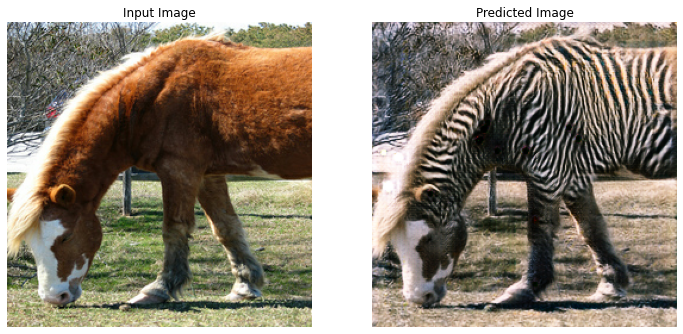

Saving checkpoint for epoch 34 at /content/drive/MyDrive/Python/zebrasGAN_data/save/ckpt-32
Time taken for epoch 34 is 1206.12 sec



In [15]:
gan = TrainGAN([d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA], ds, epochs_total=31)
gan.train(stop_after_epoch=True, calc_epoch_qty=3)

samples numbers [48 54]


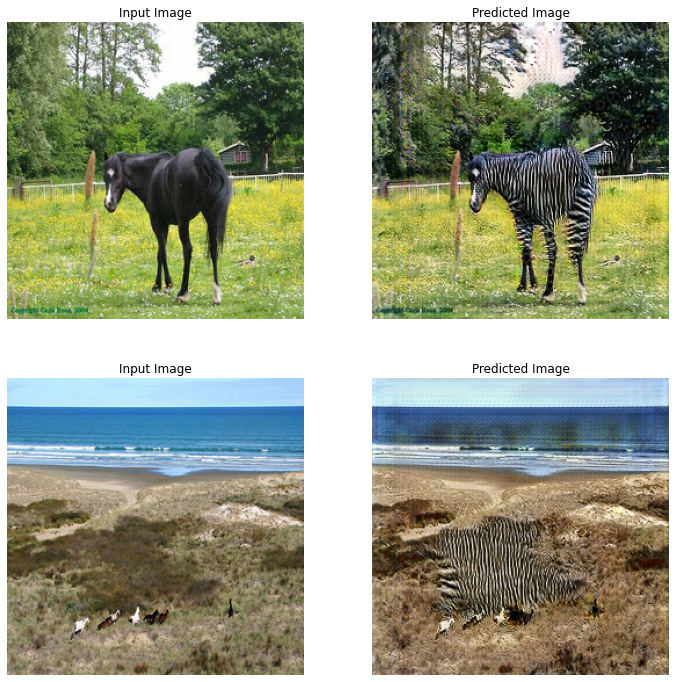

In [16]:
num_samples = 2
ix = np.random.randint(0,len(test_horses), num_samples)
print('samples numbers', ix)
samples = test_horses[ix]
generate_images(g_model_AtoB, samples)

samples numbers [12 89]


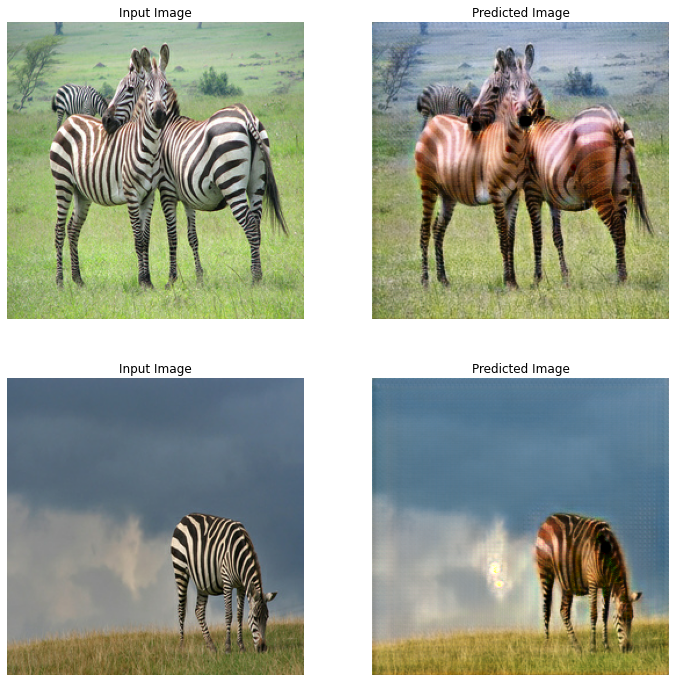

In [25]:
ix = np.random.randint(0,len(test_zebras), num_samples)
print('samples numbers', ix)
samples = test_zebras[ix]
generate_images(g_model_BtoA, samples)